**Laptop Price Prediction Using Linear Regression**
*Introduction*
This project aims to build a linear regression model to predict laptop prices based on various features such as brand, processor, RAM, hard drive type, screen size, and others. The dataset used in this project is sourced from Kaggle and includes a wide range of information on laptop specifications and their prices.

*Data Source*
The dataset for this project is sourced from the following link:
https://www.kaggle.com/datasets/muhammetvarl/laptop-price/discussion/361977.
This dataset contains detailed specifications and pricing information for laptops, making it an ideal candidate for regression analysis.

*Project Objective*
The primary objective of this project is to understand how various laptop features influence their prices and to build an effective linear regression model that can be used to predict the prices of laptops based on their specifications. This model could be beneficial for consumers seeking pricing guidance and for vendors in setting competitive prices for their products.

*Methodology*
This project follows a systematic approach to build and evaluate a linear regression model for predicting laptop prices. The methodology includes several key steps, as outlined below:

* Data Cleaning
- Handling Missing Data: Identify and address missing values in the dataset. Missing data can significantly affect regression analysis. Options for handling missing data include imputation (filling in missing values with statistical measures like mean or median) or removal of records with missing values.
- Outlier Detection and Removal: Identify and eliminate outliers, which are data points significantly different from others. Outliers can distort the analysis and model performance. Techniques such as Z-score and IQR (Interquartile Range) can be used for outlier detection.
* Feature Encoding
- Categorical Variables: Categorical variables cannot be directly used in regression models. Encoding techniques, such as one-hot encoding, are applied to transform these variables into a numerical format. This process involves creating additional binary (0 or 1) columns for each category of the variable.
* Variable Normalization
- Standardization: Ensure that numeric variables are standardized, which means they are scaled to have a mean of 0 and a standard deviation of 1. Standardization helps in comparing the influence of different variables on the model and can improve the convergence of gradient-based optimization algorithms used in model training.
* Predictions Using Different Models
- Model Exploration: Besides linear regression, explore other regression models to compare performances. Common alternatives include Ridge Regression, Lasso Regression, and Polynomial Regression. This comparative analysis can help in identifying the most suitable model for predicting laptop prices based on the given features.
* Model Evaluation
- Use appropriate metrics to evaluate the performance of the regression models. Common metrics include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² (Coefficient of Determination). These metrics provide insights into the accuracy and reliability of the predictions.

**Reading Data**

In [1]:
import pandas as pd

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_13836\2058657529.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


**Preprocessing data**


In [2]:
# When analyzing data, we encounter a few rare companies. Training a model with such a limited dataset could be impossible, so I decided to create a category 'Others' that encompasses all these rare companies.

brand_counts = df['Company'].value_counts()
small_brands = brand_counts[brand_counts < 10].index
df['Company'] = df['Company'].apply(lambda x: "Others" if x in small_brands else x)

In [3]:
# In the dataset, there are a few Operating Systems that can be categorized as more common OSes. To streamline this, I decided to unify certain Operating Systems by replacing specific versions with their more general counterparts.

df['OpSys'] = df['OpSys'].replace({'Windows 10 S': 'Windows 10', 'Mac OS X': 'macOS'})

# In the dataset, some Operating Systems are less common. To improve predictions, I categorized these rare Operating Systems under a unified label named 'OtherSys'. This was accomplished by replacing occurrences of 'Chrome OS' and 'Android' in the 'OpSys' column of the dataframe df with 'OtherSys'.

df['OpSys'] = df['OpSys'].replace(['Chrome OS', 'Android'], 'OtherSys')

In [4]:
# The 'Memory' column contains both the value and type of memory. I created a new column named 'Memory_Type' and extracted the type of memory using regex. This provided me with a column containing valuable information regarding the type of memory in each device, whether it's SSD, HDD, or Flash Storage.

df['Memory_Type'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage)', expand=False)

In [5]:
# The 'Memory' column contains values specified in GB and TB. To standardize these values, I converted all of them to GB and removed the units. This process resulted in numeric values all in a single unit of measurement, GB, making the data more consistent and easier to analyze.

import re
def convert_to_gb(value):
    unit_map = {'TB': 1024, 'GB': 1}
    match = re.search(r'(\d+)(TB|GB)', value, re.IGNORECASE)
    if match:
        num, unit = match.groups()
        return float(num) * unit_map[unit.upper()]
    else:
        return None

df['Memory_size_GB'] = df['Memory'].apply(convert_to_gb)

In [6]:
# The 'Cpu' column contains information about both the processor model and its clock frequency. To better organize this data, I split it into two separate columns. Using a lambda function, I separated the processor model and clock frequency at the last space character, resulting in two new columns: 'Processor' for the processor model and 'Clock' for the clock frequency.

df[['Processor', 'Clock']] = df['Cpu'].apply(lambda x: pd.Series(str(x).rsplit(' ', 1)))

In [7]:
# To streamline the processor information, I implemented a function called trim_processor to remove less relevant parts of the description. This function checks if the processor description starts with 'Intel'; if so, it retains only the first three words of the description. For other processors, it keeps the first two words.

def trim_processor(value):
    if value.startswith('Intel'):
        return ' '.join(value.split(' ', 3)[:3])
    else:
        return ' '.join(value.split(' ', 2)[:2])

df['Processor'] = df['Processor'].apply(trim_processor)

In [8]:
# To provide better learning models I ograniczyłem number of Processors and changed rare processors to Others

cpu_counts = df['Processor'].value_counts()
rare_cpu = cpu_counts[cpu_counts < 10].index
df['Processor'] = df['Processor'].apply(lambda x: "Others" if x in rare_cpu else x)

In [9]:
# In the columns 'Clock', 'Ram', and 'Weight', the units are consistent, so I decided to remove the units to obtain numeric values. This was achieved by applying transformation functions to each column.

df['Clock'] = df['Clock'].apply(lambda x: float(str(x).strip("GHz")))
df['Ram'] = df["Ram"].apply(lambda x: int(str(x).strip("GB")))
df['Weight'] = df["Weight"].apply(lambda x: float(str(x).strip("kg")))

In [10]:
# To disregard non-essential information, I opted to eliminate all detailed GPU information and retain only the brand. This was accomplished by creating a new column 'Gpu_Brand' in the dataframe df. I extracted the brand from the 'Gpu' column by splitting each entry at the first space and keeping only the first part, which typically represents the brand name. This approach simplifies the GPU data to focus solely on the brand, which might be sufficient for modeling purposes.

df['Gpu_Brand'] = df['Gpu'].str.split(n=1, expand=True)[0]

In [11]:
# To obtain a numeric value and simplify the screen resolution information, I decided to limit the 'Screen Resolution' data to just the 'Screen Width'. This was done by creating a new column named 'Screen_Width' in the dataframe `df'. I extracted the width from the 'ScreenResolution' column by splitting each entry from the right at the last space, taking the last part which typically contains the resolution (e.g., '1920x1080'), and then splitting this by 'x' to separate width from height. I kept only the width (the first part) and converted it to an integer. This method effectively reduces the screen resolution data to a single, numeric width value, making it more straightforward for numerical analysis or modeling.

df['Screen_Width'] = df['ScreenResolution'].str.rsplit(' ', n=1).str[-1].str.split('x').str[0].astype(int)

In [12]:
# After extracting the relevant data, I remove unnecessary columns from the dataframe to streamline it.
df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu'], axis=1)

In [13]:
# Now we can see how DataFrame looks
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Memory_size_GB,Processor,Clock,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,128.0,Intel Core i5,2.3,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,128.0,Intel Core i5,1.8,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,256.0,Intel Core i5,2.5,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,512.0,Intel Core i7,2.7,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,256.0,Intel Core i5,3.1,Intel,2560


**Cleaning data**

In [14]:
any_nan = df.isnull().values.any()
any_nan

True

In [15]:
df.dropna()
df.drop_duplicates(keep='first', inplace=True)

def remove_outliers(df, columns):
    indices_to_remove = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        indices_to_remove.update(outliers_indices)

    df_cleaned = df.drop(indices_to_remove)

    return df_cleaned
df = remove_outliers(df, ['Price_euros', "Inches", 'Ram'])

**Splitting data**

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop('Price_euros', axis=1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**One Hot Encoding**

In [17]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
columns_to_encode=['Company','TypeName', 'OpSys', 'Memory_Type', 'Gpu_Brand', "Processor"]
encoder.fit(X_train[columns_to_encode])

X_train_encoded = encoder.transform(X_train[columns_to_encode])
X_test_encoded = encoder.transform(X_test[columns_to_encode])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_test.index)

X_train_dropped = X_train.drop(columns=columns_to_encode)
X_test_dropped = X_test.drop(columns=columns_to_encode)

X_train_final = pd.concat([X_train_dropped, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_dropped, X_test_encoded_df], axis=1)

In [18]:
X_train_final.dtypes

Inches                          float64
Ram                               int64
Weight                          float64
Memory_size_GB                  float64
Clock                           float64
Screen_Width                      int32
Company_Acer                    float64
Company_Apple                   float64
Company_Asus                    float64
Company_Dell                    float64
Company_HP                      float64
Company_Lenovo                  float64
Company_MSI                     float64
Company_Others                  float64
Company_Toshiba                 float64
TypeName_2 in 1 Convertible     float64
TypeName_Gaming                 float64
TypeName_Netbook                float64
TypeName_Notebook               float64
TypeName_Ultrabook              float64
TypeName_Workstation            float64
OpSys_Linux                     float64
OpSys_No OS                     float64
OpSys_OtherSys                  float64
OpSys_Windows 10                float64


**Normalization**

In [19]:
mean_values = X_train_final.mean()
std_values = X_train_final.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                            14.999754
Ram                                6.561576
Weight                             1.958619
Memory_size_GB                   456.458128
Clock                              2.275936
Screen_Width                    1819.647783
Company_Acer                       0.092365
Company_Apple                      0.014778
Company_Asus                       0.107143
Company_Dell                       0.205665
Company_HP                         0.240148
Company_Lenovo                     0.245074
Company_MSI                        0.016010
Company_Others                     0.035714
Company_Toshiba                    0.043103
TypeName_2 in 1 Convertible        0.075123
TypeName_Gaming                    0.083744
TypeName_Netbook                   0.004926
TypeName_Notebook                  0.671182
TypeName_Ultrabook                 0.151478
TypeName_Workstation               0.013547
OpSys_Linux                        0.0

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_scaled = scaler.transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)


**Regression**

In [21]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled_df, y_train)
y_pred_linear = linear_model.predict(X_test_scaled_df)
print(f'Coefficients: {linear_model.coef_}')

Coefficients: [ 1.20402120e+01  7.96313099e+01 -5.01183332e+01  5.34837093e-01
  7.20537169e+01  7.86911649e+01 -1.90061610e+13 -1.94936729e+12
 -2.03029272e+13 -2.65318859e+13 -2.80407687e+13 -2.82349357e+13
 -8.23901120e+12 -1.21817563e+13 -1.33313632e+13 -1.16156474e+14
 -1.22067333e+14 -3.08527734e+13 -2.07020053e+14 -1.57986762e+14
 -5.09414302e+13 -7.94242284e+13 -7.94242284e+13 -3.71426504e+13
 -1.29674683e+14 -6.24979233e+13 -4.66083411e+13 -2.01636291e+14
 -4.49699889e+14 -4.62933025e+14 -8.07587886e+13  3.83043002e+14
  3.78542189e+13  5.25008291e+14  4.57790047e+14 -3.56117093e+13
 -3.93211665e+13 -7.36126476e+13 -3.35959410e+13 -1.16851500e+14
 -1.66824003e+14 -1.55766142e+14 -5.27219398e+13 -7.61747767e+13]


In [22]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)
print(f'Coefficients: {lasso_model.coef_}')


Coefficients: [  1.94953404  81.39509775 -38.68386065   0.          71.47838832
  78.14005632 -28.15684704   9.49957653 -14.20141334  -0.
  18.00275998   2.87568099  -3.025098   -12.36169319  25.56883042
  -1.00112142   0.          14.68883993 -90.73896434  30.12743519
  65.43643083 -24.95338926 -44.241397    -0.           0.
  48.8363725    1.05325115  -2.64119278  -0.          52.9777702
 -11.4483189  -13.44606359  -1.85586129  22.42384343  -0.
 -26.59169657 -30.39283645 -20.33332145   4.32664985 -30.79225136
  33.97182831  80.62737711  -0.         -30.28966364]


In [23]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)
print(f'Coefficients: {ridge_model.coef_}')


Coefficients: [ 1.34835200e+01  8.00995681e+01 -4.96352454e+01  6.48867511e-01
  7.17931997e+01  7.84872010e+01 -2.76558670e+01  7.24125061e+00
 -1.53853251e+01 -6.23009759e-03  1.81942044e+01  4.76071637e+00
 -5.72075964e+00 -1.35485167e+01  2.61329898e+01  9.58881436e+00
  1.62758727e+01  1.95118232e+01 -7.02247177e+01  4.56153257e+01
  7.12339253e+01 -2.04678316e+01 -4.10325515e+01  2.38213737e+00
  8.63748325e+00  5.41108570e+01  7.24125061e+00 -1.30462177e+01
 -2.22335792e+01  3.01822589e+01 -1.66339214e+01 -1.76432065e+01
 -2.43376405e+00  1.79416426e+01 -5.61234593e+00 -3.17752708e+01
 -3.57695004e+01 -2.91074487e+01  2.23889670e+00 -4.41267000e+01
  1.70575344e+01  6.53305883e+01 -5.81055585e+00 -3.87760412e+01]


In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train_scaled_df)
X_test_poly = poly_features.transform(X_test_scaled_df)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
print(f'Coefficients: {poly_model.coef_}')

Coefficients: [-5.81386748e+09 -1.19482358e+10 -1.22534846e+10 ...  5.61128176e+08
 -5.18628870e+09 -3.45103403e+10]


In [25]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth=3, min_samples_split=6)
tree_model.fit(X_train_scaled_df, y_train)
y_pred_tree = tree_model.predict(X_test_scaled_df)


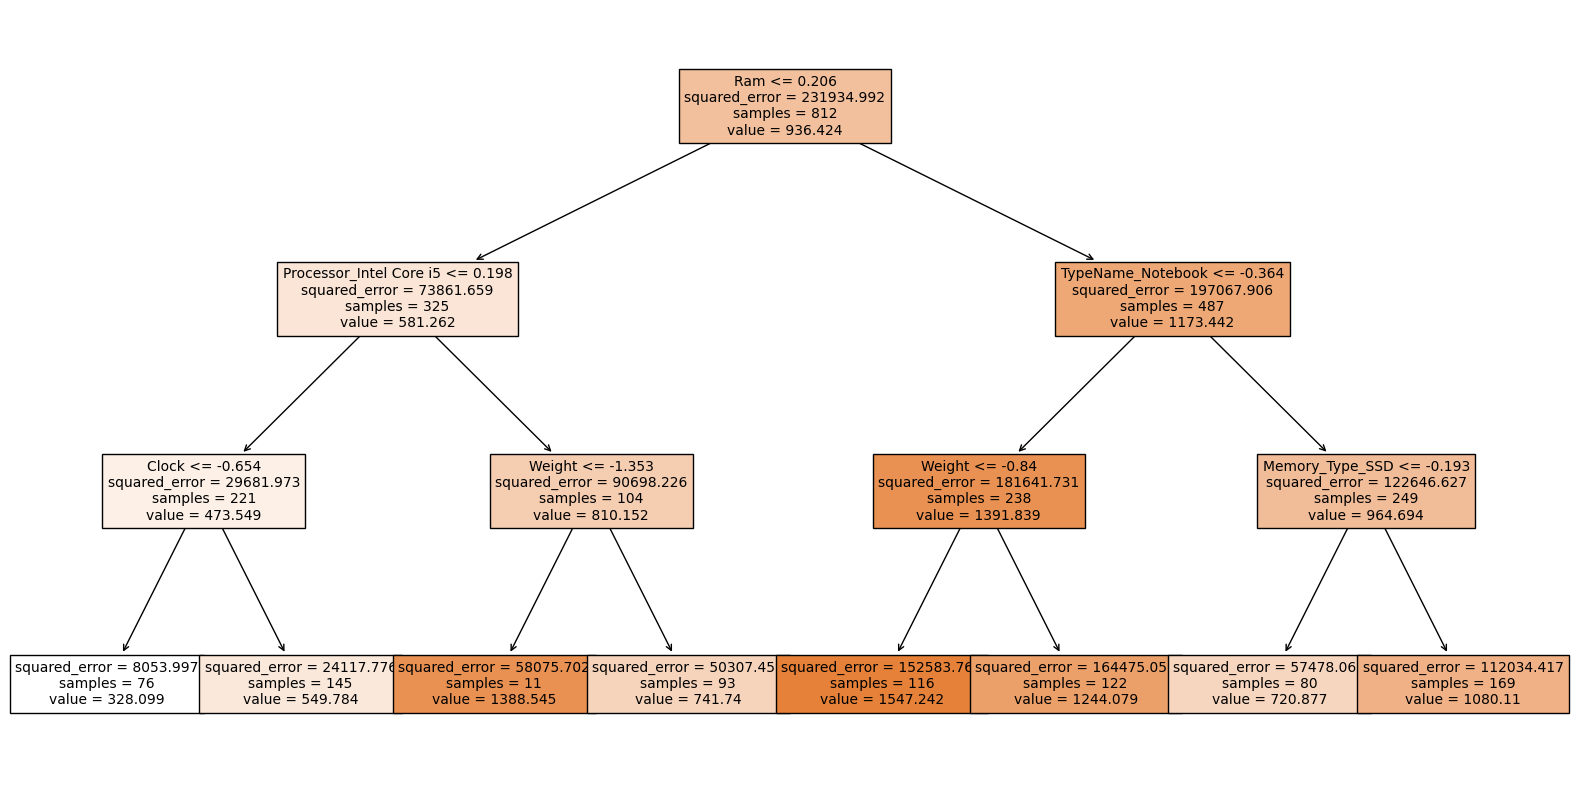

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X_test_scaled_df.columns, max_depth=3, fontsize=10)
plt.show()


**Evaluation**

In [29]:
from sklearn.metrics import r2_score, mean_squared_error
model_names = ['Linear', 'Lasso', 'Ridge', 'Polynomial', 'Decision Tree']
predictions = [y_pred_linear, y_pred_lasso, y_pred_ridge, y_pred_poly, y_pred_tree]
results = []

for model_name, pred in zip(model_names, predictions):
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    r_mse = mean_squared_error(y_test, pred, squared=False)
    results.append({"Model": model_name, "MSE": mse, "R2": r2, "RMSE": r_mse})

results_df = pd.DataFrame(results)
results_df[['MSE', 'R2', 'RMSE']] = results_df[['MSE', 'R2', 'RMSE']].applymap(lambda x: f'{x:.4f}')


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean s

In [30]:
results_df

,Model,MSE,R2,RMSE
0,Linear,66101.1031,0.7111,257.1013
1,Lasso,66130.3868,0.7110,257.1583
2,Ridge,66151.2115,0.7109,257.1988
3,Polynomial,8200108683921876330741760.0000,-35836946105503277056.0000,2863583189628.3154
4,Decision Tree,97791.1636,0.5726,312.7158



In our analysis, the Ridge, Lasso, and Linear Regression models demonstrated the best performance and achieved comparable results. Among these, the Ridge Regression model emerged as the top performer, indicating its effectiveness in handling the dataset and predicting laptop prices with a high level of accuracy. On the other hand, the Polynomial Regression model did not perform as well, showing significantly lower effectiveness in this particular case. This outcome suggests that while Polynomial Regression can be powerful for capturing non-linear relationships, it may not always be the most suitable choice, especially if the data does not exhibit strong non-linear patterns or if the model becomes too complex and overfits the data.